### Hilbert Space: LMG model

The Hamiltonian is

\begin{align*}
\mathcal{H}=\frac{2}{N}& \sum_{ij} \hat{S^z}_i \hat{S^z}_j -\sum_i \hat{S^x}_i
\end{align*}


To cconstruct the first part of Hamiltonian i.e. $H_0$ we have devided the $H_0$ in five parts. 
\begin{equation*}
\leftarrow (i-0) \rightarrow \leftarrow \hat{S_z}\rightarrow \leftarrow (j-i-1)\rightarrow \leftarrow \hat{S_z}\rightarrow\leftarrow [(N-1)-j]\rightarrow
\end{equation*}

To realize $H_0$ in hilbert space we do

identity operator of dimenstions $2^{(i-0)} \otimes \hat{S_z} \otimes$ identity operator of dimenstions $2^{(j-i-1)} \otimes \hat{S_z} \otimes$ identity operator of dimenstions $2^{[(N-1)-j]}$


And H1 in hilbert space is
identity operator of dimenstions $2^{i-0} \otimes \hat{S_x}$ identity operator of dimenstions $2^{N-1-i}$ 

running for N= 10  omega 90  with 2  processors!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1054.38it/s]


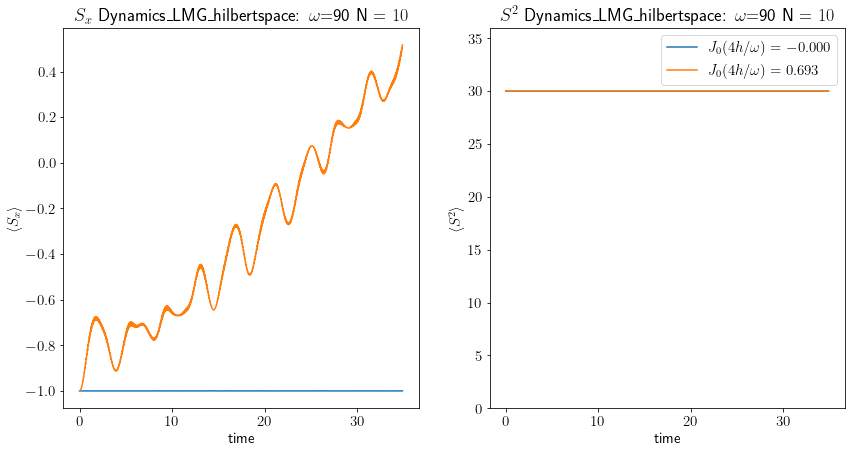

run complete!!
CPU times: user 3.94 s, sys: 1.96 s, total: 5.89 s
Wall time: 1min 25s


In [1]:
%%time
import numpy as np
from multiprocessing import Pool
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import j0, jn_zeros

freezing_pts = jn_zeros(0, 5)

sigx = 0.5 * np.array([[0,1],[1,0]])
sigy = 0.5 * np.array([[0,-1j],[1j,0]])
sigz = 0.5 * np.array([[1,0],[0,-1]])

plt.rcParams.update({
    "figure.figsize": (15,9),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Computer Modern"]})

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_floquet_zzx(N, args):
    H0, H1, sx, sy, sz = [], [], [], [], []

    
    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.kron(np.eye(2**(i-0)),\
                              np.kron(sigz,np.kron(np.eye(2**(j-i-1)),np.kron(sigz,np.eye(2**(N-1-j))))))) 
    
    for i in range(N):
        sx.append(np.kron(np.eye(2**(i-0)),np.kron(sigx,np.eye(2**(N-1-i)))))
        
    for i in range(N):
        sy.append(np.kron(np.eye(2**(i-0)),np.kron(sigy,np.eye(2**(N-1-i)))))
        
    for i in range(N):
        sz.append(np.kron(np.eye(2**(i-0)),np.kron(sigz,np.eye(2**(N-1-i)))))
    
    #beta = 0.0
    #kacN = 2 * sum([(1/j**beta) for j in range(int(np.floor(N/2)))])     # Emch Radin KacN
    
    kacN = 2/N
    
    H0 = kacN * sum(H0) * 4
    H1 = sum(sx) * 2
    
    return H0, H1, sx, sy, sz

def run_lmg_dynm(h0,h,w,N,times):
    params = {'h0':0.0, 'h':h, 'omega':w} 
    
    H0, H1, sx, sy, sz = get_floquet_zzx(N, params)
    H0, H1, Sx, Sy, Sz = Qobj(H0), Qobj(H1), Qobj(sum(sx)), Qobj(sum(sy)), Qobj(sum(sz))
    
    H = [H0,[H1,drive]]

    en, st = Sx.eigenstates()
    a = np.where(np.isclose(en, min(en)))   # Find ground state energy level number
    
    grket = st[a[0][0]]
    
    S2 =  Sx * Sx + Sy * Sy + Sz * Sz
    out = mesolve(H, grket, times, [], [H1/N, S2], args = params)
    
    return out.expect

N = 10
h0 = 0.0
w = 90      # omega: drive frequency
T = 2 * np.pi/w
times = np.linspace(0, 500 * T, 10000)

h1 = (1/4) * w * freezing_pts[0]
h2 = 26.0
hs = [h1,h2]

nprocs = 2
p = Pool(processes = nprocs)
print("running for N=",N," omega",w," with", nprocs," processors!")
data = np.array(p.starmap(run_lmg_dynm,tqdm([(h0,h,w,N,times) for h in hs])))

###################            LETS PLOTS DATA         ##########################

fig, axs = plt.subplots(1, 2, sharex='col', figsize=(14,7))

lbl1 = r"$J_0(4h/\omega)={:1.3f}$".format(j0(4*hs[0]/w))
lbl2 = r"$J_0(4h/\omega)={:1.3f}$".format(j0(4*hs[1]/w))
lbl = [lbl1,lbl2]

## S_x plot

for i in range(len(hs)):
    axs[0].plot(times,data[i][0],label=lbl[i])

axs[0].set_title(r'$S_x$ Dynamics_LMG_hilbertspace: $\omega$=90 N =  $%3d$'%N)
axs[0].set_xlabel("time")
axs[0].set_ylabel(r"$\langle S_x\rangle$")
#axs[0].legend()

## S^2 plot

for i in range(len(hs)):
    axs[1].plot(times,data[i][1],label=lbl[i])

axs[1].set_title(r'$S^2$ Dynamics_LMG_hilbertspace: $\omega$=90 N =  $%3d$'%N)
axs[1].set_xlabel("time")
axs[1].set_ylabel(r"$\langle S^2\rangle$")

s2range = N/2 *(N/2 +1)
axs[1].set_ylim(0, s2range + s2range /5)
axs[1].legend()

#figname = "sx_s2_lmg_N" + str(N) +".svg"
#plt.savefig(figname, dpi = 300)
plt.show()
print("run complete!!")

running for TSS spin= 7  omega 90.0  with 2  processors!


100%|█████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


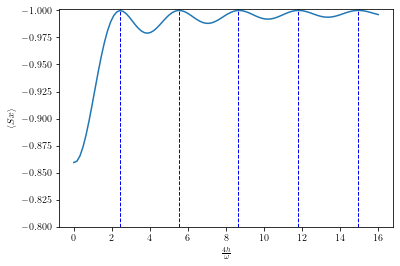

CPU times: user 7.36 s, sys: 921 ms, total: 8.28 s
Wall time: 1min 32s


In [2]:
%%time
import numpy as np
from multiprocessing import Pool
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import j0, jn_zeros
from numpy.linalg import eigh

plt.rcParams.update({
    "figure.figsize": (14,7),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 20,"font.sans-serif": ["Computer Modern"]})

sigx = 0.5 * np.array([[0,1],[1,0]])
sigy = 0.5 * np.array([[0,-1j],[1j,0]])
sigz = 0.5 * np.array([[1,0],[0,-1]])

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_lmg(N):
    H0, H1, sx, sz = [], [], [], []

    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.kron(np.eye(2**(i-0)),\
                              np.kron(sigz,np.kron(np.eye(2**(j-i-1)),\
                                                   np.kron(sigz,np.eye(2**(N-1-j))))))) 
    
    for i in range(N):
        sx.append(np.kron(np.eye(2**(i-0)),np.kron(sigx,np.eye(2**(N-1-i)))))
        
    for i in range(N):
        sz.append(np.kron(np.eye(2**(i-0)),np.kron(sigz,np.eye(2**(N-1-i)))))
        
    kacn = 2/N    
    Sx, Sz = sum(sx), sum(sz)
    
    
    H0 = kacn * sum(H0) * 4
    H1 = Sx * 2
    H0, H1, Sx, Sz = Qobj(H0), Qobj(H1), Qobj(Sx), Qobj(Sz)
    return H0, H1, Sx

def run_lmg_ipr(h,omega,T,H0, H1, Sx, nstp): 
    opts = Options(nsteps = nstp)
    params = {'h0':0.0, 'h':h, 'omega':omega}
    times = np.linspace(0,10 * T,nstp)
   
    H = [H0,[H1,drive]]
    
    en, st = H1.eigenstates()
    pp = np.where(np.isclose(en, min(en)))
    grket = st[pp[0][0]]
    out = mesolve(H, grket, times, [],\
                         [H1/N], args = params, options=opts)
    
    return np.average(out.expect)


freezing_pts = jn_zeros(0, 5)

# number of spins
N = 7       
omega = 90.0
w = omega
T = 2* np.pi/w

nstp = 1000
h_fac = 4
h1 = w/h_fac * 0.0
h2 = w/h_fac * 16.0
hsteps = 100
hs = np.linspace(h1,h2,hsteps)

H0, H1, Sx = get_ham_lmg(N)

nprocs = 2
p = Pool(processes = nprocs)
print("running for TSS spin=",N," omega",w," with", nprocs," processors!")

data = np.array(p.starmap(run_lmg_ipr,tqdm([(h,omega,T,H0, H1, Sx, nstp) for h in hs])))

for pt in freezing_pts:
    plt.axvline(x=pt, color='blue', linestyle="--",linewidth=1.0)

plt.plot(4 * hs/omega ,data)
plt.ylim(-.8,-1.001)
plt.xlabel(r"$\frac{4h}{\omega}$")
plt.ylabel(r"$\langle Sx \rangle$")
plt.show()

## TSS

Consider the Hamiltonian of the type
\begin{equation}
\hat{H}(t) = \hat{H}_0 + \left(h \cos{(\omega t)} + h_0\right)\; \hat{H}_1,
\end{equation}

where

\begin{eqnarray}
\hat{H}_0 &=& \sum_{ij}J_{ij}\hat{\sigma}^z_i\hat{\sigma}^z_j,\\
\hat{H}_1 &=& \sum_i\hat{\sigma}^x_i.
\end{eqnarray}
here, $J_{ij} = \frac{2}{N}$

So the Hamiltonian is
\begin{align*}
\mathcal{H}=\frac{2}{N}& \sum_{ij} \hat{\sigma^z}_i \hat{\sigma^z}_j -\sum_i \hat{\sigma^x}_i
\end{align*}


First, define permutation operator $P_{ij} = \displaystyle\frac{1}{2}\left(1+ \vec{\sigma}_i\cdot\vec{\sigma}_j\right)$,
and note that $[P_{ij}, H]=0$. Thus, we can reduce the problem size from the full $2^N\times 2^N$ Hilbert space
to the subspace spanned by the degenerate eigenvectors of $P_{ij}$ corresponding to a single eigenvalue, say $1$.
This is isomorphic to the subspace spanned by degenerate eigenstates of the operator $\hat{S}^2_{tot}=|\vec{S}|^2$ with eigenvalue
$\displaystyle\frac{N}{2}\left(\frac{N}{2}+1\right)$ with $\hat{S_{tot}}:=\sum_{i=1}^N\hat{\sigma_i}/2$.

Note that, since $[S^2, S^z]=0$, these are also eigenstates of $S^z$ in this so-called
TSS subspace. The corresponding eigenvalues are $Ns_n$, where $s_n=-\frac{1}{2}+\frac{n}{N}$ and the index
$n= 0 (1) N$ has $N+1$ values. Thus

\begin{equation}
S^z |s_n\rangle = Ns_n|s_n\rangle,
\end{equation}

and the matrix elements $(S^z)_{ij} = Ns_s\delta_{ij}$. Furthermore, defining ladder operators

\begin{equation}
S_\pm \equiv S^x \pm i S^y,
\end{equation}

and using the result

\begin{equation}
S_\pm |s_n\rangle = \sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n\pm 1}\right)}\;\;|s_{n\pm 1}\rangle,
\end{equation}

we can obtain the matrix elements $S^x = S_+ + S_-$ to be

\begin{multline}
(S^x)_{nm} = \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n + 1}\right)}\;\;\delta_{n+1, m}  +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n- 1}\right)}\;\;\delta_{n-1,m}\bigg]
\end{multline}

Note that, condidering $i<j$ the Hamiltonian can be readily written as
$H(t) = -\displaystyle\frac{2}{N}(S^z)^2 - (h \cos{(\omega t )} + h_0)S^x$, the matrix elements of
\begin{eqnarray}
\left(H_0\right)_{ij} &=& -\frac{2}{N} s^2_i \delta_{ij},\nonumber\\
\left(H_1\right)_{ij} &=& \bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i + 1}\right)}\;\;\delta_{i+1, j}  +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i- 1}\right)}\;\;\delta_{i-1,j}\bigg]
\end{eqnarray}

Note that, in the continuum limit, $N\rightarrow\infty$, we can ignore the difference between adjacent values
of $s_i$. Thus, the Hamiltonian per particle becomes $h(t)\equiv \displaystyle\frac{1}{N}H(t) = h + h_0\cos{(\omega t)}h_1$, where

## Relation between  :  TSS and Hilbert Space 

Now we have to understand the relation between Totally Symmetric Subspace (TSS) and Hilbert space representaion.
In Hilbert space spin-1/2 case,TSS corresponds to the subspace with maximum total spin length, $\hat{S}^2_{tot} = (N/2)(N/2+1)$ with $\hat{S}_{tot}:=\sum^N_{i=1}\hat{\sigma}_i/2$. 

Within the TSS, the model with $\alpha = 0$ can be considered to be a seclassical syste, with the effective Planck constant $\hbar_{eff}=1/N$. In the spin-1/2 system, any state $|\Psi(t)\rangle$ in the TSS is expanded as $|\Psi(t)\rangle =\sum_q \Psi_t (q)|q\rangle$, where $|q\rangle$ is a simultaneuous eigenstate of $\hat{S^2}_{tot}$ and $\hat{S^z}_{tot}$ with eigenvalues(N/2)(N/2+1) and Nq respectively, where $Nq \epsilon {-N/2, -N/2+1,.... ,N/2}$. 

We know in general, the for considered spin $"s"$ for which $\hat{S^2} = s(s+1)$.
Now for Hilbert space spin 1/2 system (i.e. q= 1/2) with N spin lattice point we have $Nq= N/2$ and it ranges in between {$-N/2, -N/2+1,.... ,N/2$}. This is the case where $\hat{S^2}_{tot}= (N/2)(N/2+1)$.

So when we are numerically (in computer) studying LMG model which is basically in Hilbert space, the Hamiltonian becomes ($2^N \times 2^N$) matrix. So when we take larger system size with larger N. The computer RAM memory is never sufficient (till today's technology). We canover come this problem using TSS.

In Hilbert space representation, we take a long spin-1/2 chain with spin lattice size N and we usually sum up all the possible two spin orientations all over the spin chain. For this case considered spin is $s = N/2$. 

In TSS we find spin "s" and corresponding $\hat{S^2} = s(s+1), and \hat{S^x}, \hat{S^y}, \hat{S^z}$

So to get consistency in TSS and Hilber space we have to do


<ol>
<li> Hilbert space spin length $N_{Hilbert}$ = TSS spin $\frac{N_{TSS}}{2}$ </li>
<li> In TSS to get $\hat{S}_{tot}:=\sum^N_{i=1}\hat{\sigma}_i/2$</li>
<ol>
    
    
Our Hamiltonian is 
    
\begin{align*}
\mathcal{H} =& \frac{N}{2}H_0 + H_1\\
    =& \frac{N}{2}\hat{S^z}\hat{S^z} + 2 \times \hat{S^x_{tot}}
\end{align*}
    
Here we shall put $H_0 = \hat{S^z}\hat{S^z} $ and $H_1 = 2 \times \hat{S^x_{tot}}$ (from (2))

### Compare TSS and LMG

running for TSS spin= 5.0  omega 90  with 2  processors!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 369.10it/s]


running for LMG N= 10  omega 90  with 2  processors!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 328.36it/s]


CPU times: user 590 ms, sys: 62.6 ms, total: 652 ms
Wall time: 3min 57s


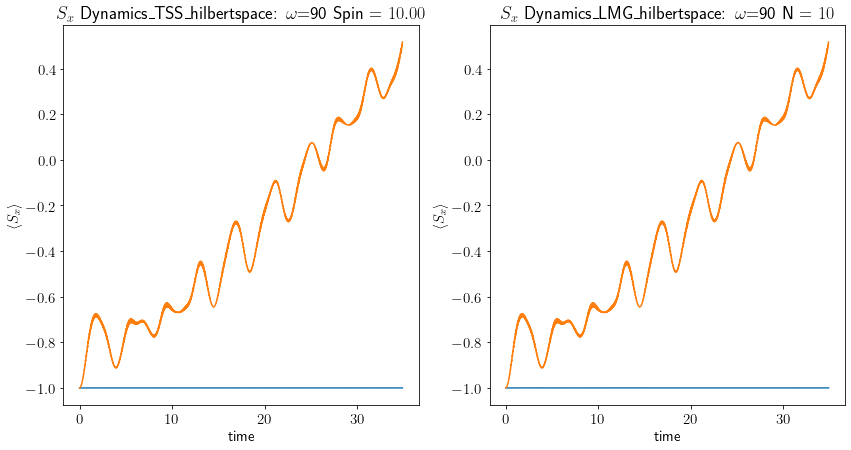

In [4]:
%%time
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool
from scipy.special import j0, jn_zeros
import numpy as np
freezing_pts = jn_zeros(0, 5)

sigx = 0.5 * np.array([[0,1],[1,0]])
sigy = 0.5 * np.array([[0,-1j],[1j,0]])
sigz = 0.5 * np.array([[1,0],[0,-1]])

def drive(t, args):
    h0, h, w = args['h0'], args['h'], args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_tss(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/N
    H0 = kn * sz **2
    H1 = 2 * sx
    return H0,H1,sx,sy,sz

def run_dynm_tss(h,omega,times,N_tss):
    N = N_tss
    params = {'h0':0.0, 'h':h, 'omega':omega}
        
    H0, H1, Sx, Sy, Sz = get_ham_tss(N)
    
    en, st = (H1).eigenstates()
    #a = np.where(np.isclose(en, 1.0, rtol=1e-05, atol=1e-08))
    #print("en",en,"\npoint\n", a[0][0])
    a = np.where(np.isclose(en, min(en)))
    grket = st[a[0][0]]
    
    H = [H0,[H1,drive]]

    S2 =  Sx * Sx + Sy * Sy + Sz * Sz 
    out = mesolve(H, grket, times,[], [H1/(2*N), S2], args = params)
    return out.expect


def get_floquet_zzx_lmg(N_lmg, args):
    H0, H1, sx, sy, sz = [], [], [], [], []
    N = N_lmg
    
    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.kron(np.eye(2**(i-0)),\
                              np.kron(sigz,np.kron(np.eye(2**(j-i-1)),np.kron(sigz,np.eye(2**(N-1-j))))))) 
    
    for i in range(N):
        sx.append(np.kron(np.eye(2**(i-0)),np.kron(sigx,np.eye(2**(N-1-i)))))
        
    for i in range(N):
        sy.append(np.kron(np.eye(2**(i-0)),np.kron(sigy,np.eye(2**(N-1-i)))))
        
    for i in range(N):
        sz.append(np.kron(np.eye(2**(i-0)),np.kron(sigz,np.eye(2**(N-1-i)))))
    
    kacN = 2/N
    
    H0 = kacN * sum(H0) * 4
    H1 = sum(sx) * 2
    
    return H0, H1, sx, sy, sz

def run_lmg_dynm(h0,h,w,N_lmg,times):
    N = N_lmg
    params = {'h0':0.0, 'h':h, 'omega':w} 
    
    H0, H1, sx, sy, sz = get_floquet_zzx_lmg(N, params)
    H0, H1, Sx, Sy, Sz = Qobj(H0), Qobj(H1), Qobj(sum(sx)), Qobj(sum(sy)), Qobj(sum(sz))
    
    H = [H0,[H1,drive]]

    en, st = H1.eigenstates()
    a = np.where(np.isclose(en, min(en)))   # Find ground state energy level number
    
    grket = st[a[0][0]]
    
    S2 =  Sx * Sx + Sy * Sy + Sz * Sz
    out = mesolve(H, grket, times, [], [H1/N, S2], args = params)
    
    return out.expect


if __name__ == '__main__':
    
    N = 10
    N_tss = N/2.0             #total spin in TSS
    h0 = 0.00
    omega = 90
    w = omega
    T = 2 * np.pi/w
    hs = [(1/4) * omega * freezing_pts[2], 26]
    times = np.linspace(0, 500 * T, 50000)
    nprocs = 2
    p = Pool(processes = nprocs)
    print("running for TSS spin=",N_tss," omega",w," with", nprocs," processors!")
    
    data_tss = np.array(p.starmap(run_dynm_tss,tqdm([(h,omega,times,N_tss) for h in hs])))
    
    
    fig, axs = plt.subplots(1, 2, sharex='col', figsize=(14,7))

    lbl1 = r"$J_0(4h/\omega)={:1.3f}$".format(j0(4*hs[0]/w))
    lbl2 = r"$J_0(4h/\omega)={:1.3f}$".format(j0(4*hs[1]/w))
    lbl = [lbl1,lbl2]

    for i in range(len(hs)):
        axs[0].plot(times,data_tss[i][0],label=lbl[i])

    axs[0].set_title(r'$S_x$ Dynamics_TSS_hilbertspace: $\omega$=90 Spin =  $%4.2f$'%N)
    axs[0].set_xlabel("time")
    axs[0].set_ylabel(r"$\langle S_x\rangle$")
    #axs[0].legend()
    
    
    #--------------------lmg
    N_lmg = N                          # spin chain lenth
    h0 = 0.0
    #w = 90      # omega: drive frequency
    #T = 2 * np.pi/w
    #times = np.linspace(0, 5 * T, 1000)

    h1 = (1/4) * w * freezing_pts[0]
    h2 = 26.0
    hs = [h1,h2]

    nprocs = 2
    p = Pool(processes = nprocs)
    print("running for LMG N=",N_lmg," omega",w," with", nprocs," processors!")
    data_lmg = np.array(p.starmap(run_lmg_dynm,tqdm([(h0,h,w,N_lmg,times) for h in hs])))
    
    lbl1 = r"$J_0(4h/\omega)={:1.3f}$".format(j0(4*hs[0]/w))
    lbl2 = r"$J_0(4h/\omega)={:1.3f}$".format(j0(4*hs[1]/w))
    lbl = [lbl1,lbl2]

    ## S_x plot

    for i in range(len(hs)):
        axs[1].plot(times,data_lmg[i][0],label=lbl[i])

    axs[1].set_title(r'$S_x$ Dynamics_LMG_hilbertspace: $\omega$=90 N =  $%3d$'%N)
    axs[1].set_xlabel("time")
    axs[1].set_ylabel(r"$\langle S_x\rangle$")
    #axs[0].legend()

# IPR

### 1.  IPR: LMG

##### floquet Basis changed sz->sx 

#### IPR: TSS

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


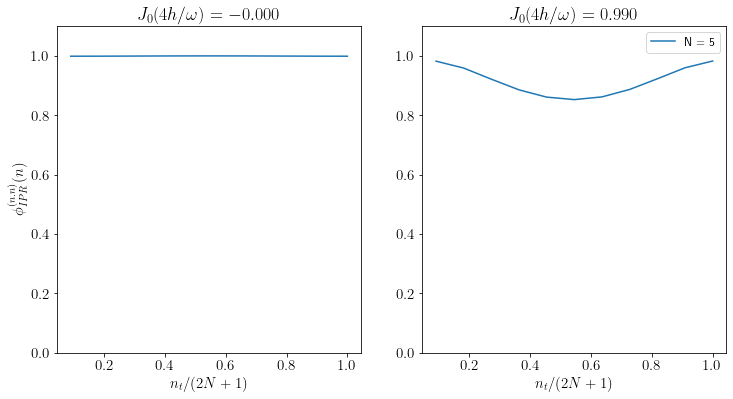

CPU times: user 10 s, sys: 1.6 s, total: 11.6 s
Wall time: 12.4 s


In [1]:
%%time
import numpy as np
from multiprocessing import Pool
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import j0, jn_zeros
from numpy.linalg import eigh

plt.rcParams.update({
    "figure.figsize": (12,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Computer Modern"]})

opts = Options(nsteps=500)

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_qutip(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/N                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1,sx,sy,sz

def get_iprvals(N, times, params):    
    H0, H1, sx, sy, sz = get_ham_qutip(N)
    H = [H0,[H1,drive]]
    
    f_mat = []
    for i in range(int(2*N+1)):
        baseket = basis(int(2*N+1),i)
        solv_state = mesolve(H, baseket, times, [], [], args = params)
        f_mat.append(np.array(solv_state.states)[-1])
        
    f_monodromy = np.array(f_mat)[:,:,0]
    
    sx, floquet_matrix = jmat(N,"x"), []
    en, st = sx.eigenstates()
    #st_f = np.array([st[i] for i in range(int(2*N +1))])[:,:,0]
    
    floquet_matrix = Qobj(f_monodromy).transform(st)
    #floquet_matrix = [Qobj(st_f) * f_monodromy[i] for i in range(int(2*N+1))]
    
    return np.sum(np.abs(np.array(floquet_matrix))**4, axis=1)

fig, (ax0, ax1) = fig, axs = plt.subplots(1, 2)

freezing_pts = jn_zeros(0, 5)

Nvals = [5]            # number of spins
omega = 90.0
w = omega
T = 2* np.pi/w
nsteps = 1000
times = np.linspace(0, T, nsteps)

h1 = w/4 * freezing_pts[3]
h2 = w/4 * .2

h = h1
params = {'h0':0.0, 'h':h, 'omega':omega}
ax0.set_title(fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")
ax0.set_ylim(0.0,1.1)
for N in tqdm(Nvals):
    idxvals = np.arange(1,2*N+1 +1)/(2*N+1)
    ax0.plot(idxvals, get_iprvals(N, times, params), label=f'N = {N}')

h = h2
params = {'h0':0.0, 'h':h, 'omega':omega}
ax1.set_title(fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")
ax1.set_ylim(0.0,1.1)
for N in tqdm(Nvals):
    idxvals = np.arange(1,2*N+1 +1)/(2*N+1)
    ax1.plot(idxvals, get_iprvals(N, times, params), label=f'N = {N}')
    
for ax in (ax0, ax1):
    ax.set_xlabel(r'$n_{t}/(2N+1)$')
    
ax0.set_ylabel(r'$\phi^{(n.n)}_{IPR}(n)$')
ax1.legend(fontsize=12)
plt.show()

running for TSS spin= 5  omega 90.0  with 10  processors!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.36it/s]


run complete!
CPU times: user 1.28 s, sys: 1.08 s, total: 2.36 s
Wall time: 33.7 s


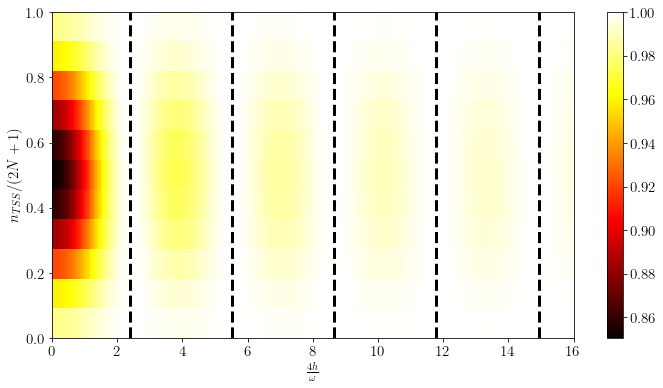

In [2]:
%%time
import numpy as np
from multiprocessing import Pool
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import j0, jn_zeros
from numpy.linalg import eigh

plt.rcParams.update({
    "figure.figsize": (12,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Computer Modern"]})

opts = Options(nsteps=500)

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_qutip(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/N                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1,sx,sy,sz

def run_tss_ipr(h,omega,times,H0, H1, sx, sy, sz):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    H = [H0,[H1,drive]]
    
    f_mat = []
    for i in range(int(2*N+1)):
        baseket = basis(int(2*N+1),i)
        solv_state = mesolve(H, baseket, times, [], [], args = params)
        f_mat.append(np.array(solv_state.states)[-1])
        
    f_monodromy = np.array(f_mat)[:,:,0]
    
    sx, floquet_matrix = jmat(N,"x"), []
    en, st = sx.eigenstates()
    #st_f = np.array([st[i] for i in range(int(2*N +1))])[:,:,0]
    
    floquet_matrix = Qobj(f_monodromy).transform(st)
    #floquet_matrix = [Qobj(st_f) * f_monodromy[i] for i in range(int(2*N+1))]
    
    return np.sum(np.abs(np.array(floquet_matrix))**4, axis=1)


freezing_pts = jn_zeros(0, 5)

# number of spins
N = 5       
omega = 90.0
w = omega
T = 2* np.pi/w

nsteps = 200
times = np.linspace(0,T, nsteps)
h1 = w/4 * 0.0
h2 = w/4 * 16.0
hsteps = 300
hs = np.linspace(h1,h2,hsteps)

H0, H1, sx, sy, sz = get_ham_qutip(N)

nprocs = 10
p = Pool(processes = nprocs)
print("running for TSS spin=",N," omega",w," with", nprocs," processors!")

iprmat = np.array(p.starmap(run_tss_ipr,tqdm([(h,omega,times,H0, H1, sx, sy, sz) for h in hs])))
print("run complete!")

minmin = np.min(iprmat)
maxmax = np.max(iprmat)
asp = 10
plt.xlabel(r'$\frac{4h}{\omega}$')
plt.ylabel(r'$n_{TSS}/(2N+1)$')
etas = 4 * hs/w

for pt in freezing_pts:
    plt.axvline(x=pt, color='black', linestyle="--",linewidth=3.0)

plt.imshow(iprmat.T, aspect=asp, interpolation='None',\
                cmap='hot', origin='lower',\
           extent = [etas[0] ,etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

plt.colorbar()

running for TSS spin= 5  omega 90.0  with 2  processors!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1231.81it/s]


run complete!


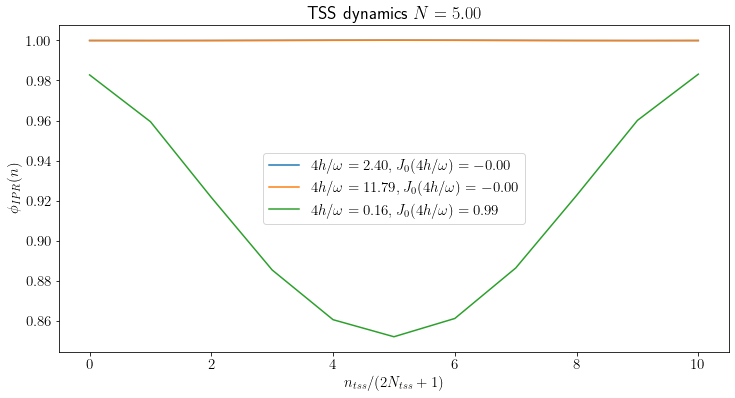

CPU times: user 1.6 s, sys: 1.24 s, total: 2.84 s
Wall time: 4.52 s


Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 366, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.10/multiprocessing/synchronize.py

In [3]:
%%time
import numpy as np
from multiprocessing import Pool
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import j0, jn_zeros
from numpy.linalg import eigh

plt.rcParams.update({
    "figure.figsize": (12,6),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Computer Modern"]})

opts = Options(nsteps=500)

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_qutip(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/N                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1,sx,sy,sz

def run_tss_ipr(h,omega,times,H0, H1, sx, sy, sz):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    H = [H0,[H1,drive]]
    
    f_mat = []
    for i in range(int(2*N+1)):
        baseket = basis(int(2*N+1),i)
        solv_state = mesolve(H, baseket, times, [], [], args = params)
        f_mat.append(np.array(solv_state.states)[-1])
        
    f_monodromy = np.array(f_mat)[:,:,0]
    
    sx, floquet_matrix = jmat(N,"x"), []
    en, st = sx.eigenstates()
    #st_f = np.array([st[i] for i in range(int(2*N +1))])[:,:,0]
    
    floquet_matrix = Qobj(f_monodromy).transform(st)
    #floquet_matrix = [Qobj(st_f) * f_monodromy[i] for i in range(int(2*N+1))]
    
    return np.sum(np.abs(np.array(floquet_matrix))**4, axis=1)


freezing_pts = jn_zeros(0, 5)

# number of spins
N = 5       
omega = 90.0
w = omega
T = 2* np.pi/w

h1 = w/4*freezing_pts[0]
h2 = w/4*freezing_pts[3]
h3 = 3.5
hs = [h1,h2,h3]

H0, H1, sx, sy, sz = get_ham_qutip(N)

nprocs = 2
p = Pool(processes = nprocs)
print("running for TSS spin=",N," omega",w," with", nprocs," processors!")

iprmat = np.array(p.starmap(run_tss_ipr,tqdm([(h,omega,\
                                               times,H0, H1, sx, sy, sz) for h in hs])))
print("run complete!")

plt.title(fr"TSS dynamics $ N={N:3.2f}$")
plt.ylabel(r"$\phi_{{IPR}}(n)$")
plt.xlabel(r"$n_{tss}/(2N_{tss}+1)$")
[plt.plot(np.arange(int(2*N+1)),iprmat[i], \
          label=fr"$4h/\omega={4*hs[i]/w:1.2f}, J_0(4h/\omega)={j0(4*hs[i]/w):1.2f}$") \
 for i in range(len(hs))]
plt.legend()
plt.show()

### Note: 

So far we have investigated IPR for TSS in ZZX spin orientation, and the outcome result seems to follow the theoretical assumptions. Mahbub has already checked :
(1) TSS code in XXZ model with basis changed method and (2)not changed method. Basically we need not to change the basis when we are projecting our transverse symmetry breaking field in Z direction, because $\sigma_z$ is diagonalied itself. 

When we study ZZX we have to rotate the basis towards $\sigma_x$ because $\sigma_x$ is not diagonal itself.

#### Comparision LMG and TSS

functions defined
LMG completed 
TSS completed 


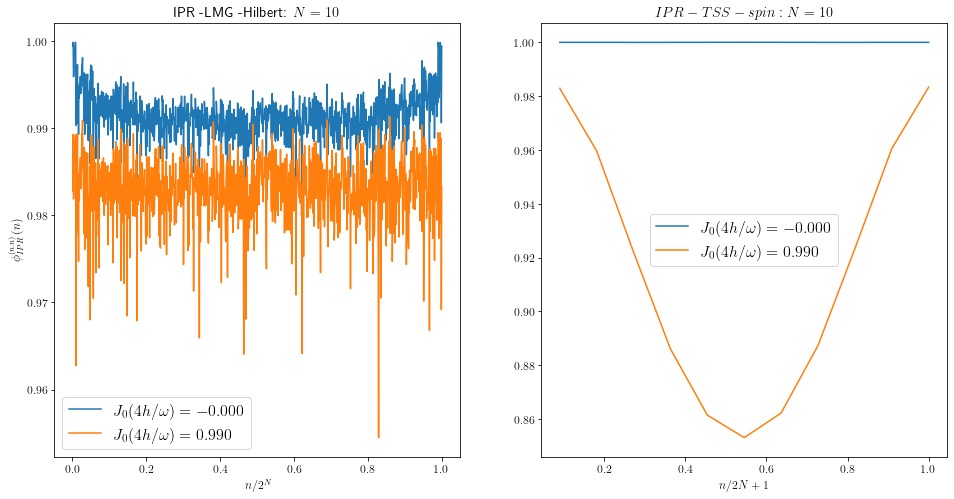

CPU times: user 2min 12s, sys: 17.3 s, total: 2min 30s
Wall time: 1min 57s


In [4]:
%%time
import numpy as np
from multiprocessing import Pool
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import j0, jn_zeros
from numpy.linalg import eigh, eig

plt.rcParams.update({
    "figure.figsize": (16,8),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Computer Modern"]})

sigx = 0.5 * np.array([[0,1],[1,0]])
sigy = 0.5 * np.array([[0,-1j],[1j,0]])
sigz = 0.5 * np.array([[1,0],[0,-1]])

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_ham_lmg(N):
    H0, H1, sx, sz = [], [], [], []

    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.kron(np.eye(2**(i-0)),\
                              np.kron(sigz,np.kron(np.eye(2**(j-i-1)),\
                                                   np.kron(sigz,np.eye(2**(N-1-j))))))) 
    
    for i in range(N):
        sx.append(np.kron(np.eye(2**(i-0)),np.kron(sigx,np.eye(2**(N-1-i)))))
        
    for i in range(N):
        sz.append(np.kron(np.eye(2**(i-0)),np.kron(sigz,np.eye(2**(N-1-i)))))
        
    kacn = 2/N    
    Sx, Sz = sum(sx), sum(sz)
    
    
    H0 = kacn * sum(H0) * 4
    H1 = 2 * Sx
    H0, H1, Sx, Sz = Qobj(H0), Qobj(H1), Qobj(Sx), Qobj(Sz)
    enn, stt = Sz.eigenstates() 
    return H0, H1, Sx, Sz

def get_iprvals_lmg(N, opts, T, params):    
    H0, H1, Sx, Sz = get_ham_lmg(N)
    H = [H0,[H1,drive]]
    
    f_mat = []
    for i in range(int(2**N)):
        baseket = basis(2**N,i)
        solv_state = mesolve(H, baseket, (0,T), [], [], args = params, options=opts)
        f_mat.append(np.array(solv_state.states)[-1])
        
    f_monodromy = np.array(f_mat)[:,:,0]
    en, st_sx = Sx.eigenstates()
    floquet_matrix = Qobj(f_monodromy).transform(st_sx)
    return np.sum(np.abs(np.array(floquet_matrix))**4, axis=1)

def get_ham_qutip_tss(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kacn =  2/N                                      # kacNorm
    H0 = kacn * sz **2
    H1 = 2 * sx
    return H0,H1,sx,sy,sz


def get_iprvals_tss(N, times, opts, params):    
    H0, H1, sx, sy, sz = get_ham_qutip_tss(N)
    H = [H0,[H1,drive]]
    
    f_mat = []
    for i in range(int(2*N+1)):
        baseket = basis(int(2*N+1),i)
        solv_state = mesolve(H, baseket, (0,T), [], [], args = params, options=opts)
        f_mat.append(np.array(solv_state.states)[-1])
    f_monodromy = np.array(f_mat)[:,:,0]
    sx, floquet_matrix = jmat(N,"x"), []
    en, st = sx.eigenstates()
    
    floquet_matrix = Qobj(f_monodromy).transform(st)    
    return np.sum(np.abs(np.array(floquet_matrix))**4, axis=1)

print("functions defined")

fig, (ax0, ax1) = fig, axs = plt.subplots(1, 2)
freezing_pts = jn_zeros(0, 5)
omega = 90.0
w = omega
T = 2* np.pi/w
nsteps = 1000
times = np.linspace(0, T, nsteps)
opts = Options(nsteps=1000)

#------LMG--------------
N = 10   
N_lmg = N
omega = 90.0
w = omega
T = 2 * np.pi/w
opts = Options(nsteps=500)

h1 = w/4 * freezing_pts[0]
h2 = w/4 * 0.2

h = h1
params = {'h0':0.0, 'h':h, 'omega':omega}
idxvals = np.arange(1,2**N+1)/2**N
ax0.plot(idxvals, get_iprvals_lmg(N, opts, T,params),\
         label=fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")

h = h2
params = {'h0':0.0, 'h':h, 'omega':omega}
idxvals = np.arange(1,2**N+1)/2**N
ax0.plot(idxvals, get_iprvals_lmg(N, opts, T, params),\
         label=fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")
    
ax0.set_title(fr"IPR -LMG -Hilbert: $N={N}$")
print("LMG completed ")
#####################-------- TSS------------
N = N_lmg/2.0 

h1 = w/4 * freezing_pts[0]
h2 = w/4 * 0.2

h = h1
params = {'h0':0.0, 'h':h, 'omega':omega}
opts = Options(nsteps=5000)
idxvals = np.arange(1,2*N+1 +1)/(2*N+1)
ax1.plot(idxvals, get_iprvals_tss(N, times, opts, params),\
         label=fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")

h = h2
params = {'h0':0.0, 'h':h, 'omega':omega}
idxvals = np.arange(1,2*N+1 +1)/(2*N+1)
ax1.plot(idxvals, get_iprvals_tss(N, times, opts, params),\
         label=fr"$J_0(4h/\omega)={j0(4*h/w):1.3f}$")

print("TSS completed ")
#######################
    
ax0.set_xlabel(r'$n/2^N$')  
ax0.set_ylabel(r'$\phi^{(n.n)}_{IPR}(n)$')
#ax0.set_ylim(0.0,1.1)
ax0.legend(fontsize=16)

ax1.set_title(fr"$IPR -TSS - spin: N={N_lmg}$")
ax1.set_xlabel(r'$n/2N+1$')
#ax1.set_ylim(0.0,1.1)
ax1.legend(fontsize=16)

plt.show()

In [ ]:
%%time
import numpy as np
from multiprocessing import Pool
from qutip import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import j0, jn_zeros
from numpy.linalg import eigh

plt.rcParams.update({
    "figure.figsize": (20,8),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 25,"font.sans-serif": ["Computer Modern"]})

sigx = 0.5 * np.array([[0,1],[1,0]])
sigy = 0.5 * np.array([[0,-1j],[1j,0]])
sigz = 0.5 * np.array([[1,0],[0,-1]])

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)
#----------------------------------------------------------------------- Hilbert LMG
def get_ham_lmg(N):
    H0, H1, sx, sz = [], [], [], []

    for i in range(N-1):
        for j in range(i+1,N):
            H0.append(np.kron(np.eye(2**(i-0)),\
                              np.kron(sigz,np.kron(np.eye(2**(j-i-1)),\
                                                   np.kron(sigz,np.eye(2**(N-1-j))))))) 
    
    for i in range(N):
        sx.append(np.kron(np.eye(2**(i-0)),np.kron(sigx,np.eye(2**(N-1-i)))))
        
    for i in range(N):
        sz.append(np.kron(np.eye(2**(i-0)),np.kron(sigz,np.eye(2**(N-1-i)))))
        
    kacn = 2/N    
    Sx, Sz = np.sum(sx,axis=0), np.sum(sz,axis=0)
    
    
    H0 = kacn * np.sum(H0,axis=0) * 4
    H1 = 2 * Sx
    H0, H1, Sx, Sz = Qobj(H0), Qobj(H1), Qobj(Sx), Qobj(Sz)
    return H0, H1, Sx, Sz

def run_lmg_ipr(h,omega,T,H0, H1, Sx, opts): 
    params = {'h0':0.1, 'h':h, 'omega':omega}
    H = [H0,[H1,drive]]
    en, st_sx = Sx.eigenstates()
    f_mat = []
    for i in range(int(2**N)):
        baseket = basis(2**N,i)
        solv_state = mesolve(H, baseket, (0,T), [], [], args = params, options=opts)
        f_mat.append(np.array(solv_state.states)[-1])
    
    #floquet_matrix = np.array(f_mat)[:,:,0]
    #return np.sum(np.abs(floquet_matrix)**4, axis=1)
    fl_mat = Qobj(np.array(f_mat)[:,:,0]).transform(st_sx)
    return np.sum(np.abs(np.array(fl_mat))**4, axis=1)

#---------------------------------------------------------------- ----------TSS
def get_ham_qutip(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/N                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1,sx,sy,sz

def run_tss_ipr(h,omega,T,H0, H1, sx, sy, sz,opts):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    H = [H0,[H1,drive]]
    
    f_mat = []
    for i in range(int(2*N+1)):
        baseket = basis(int(2*N+1),i)
        solv_state = mesolve(H, baseket, (0,T), [], [], args = params, options=opts)
        f_mat.append(np.array(solv_state.states)[-1])
        
    f_monodromy = np.array(f_mat)[:,:,0]
    
    sx, floquet_matrix = jmat(N,"x"), []
    en, st = sx.eigenstates()
    #st_f = np.array([st[i] for i in range(int(2*N +1))])[:,:,0]
    
    floquet_matrix = Qobj(f_monodromy).transform(st)
    #floquet_matrix = [Qobj(st_f) * f_monodromy[i] for i in range(int(2*N+1))]
    
    return np.sum(np.abs(np.array(floquet_matrix))**4, axis=1)
#--------------------------------------------------------------------------------------
nprocs = 10
freezing_pts = jn_zeros(0, 5)

N = 10               #Spin length of consideration
N_lmg = N
N_tss = N/2.0
omega = 90.0        #frequency of the drive field
w = omega
T = 2* np.pi/w
nstp = 10000         # number of steps mesolve will iterate
opts = Options(nsteps = nstp) 
h_fac = 4
h1 = w/h_fac * 0.0
h2 = w/h_fac * 10.0
hsteps = 100
hs = np.linspace(h1,h2,hsteps)
#---------------------------------------------------------------------------------------
p1 = Pool(processes = nprocs)
H0, H1, Sx, Sz = get_ham_lmg(N)
print("running for LMG spin=",N_lmg," omega",w," with", nprocs," processors!")
iprmat_lmg = np.array(p1.starmap(run_lmg_ipr,tqdm([(h,omega,T,H0, H1, Sx, opts) for h in hs])))
#---------------------------------------------------------------------------------------
p2 = Pool(processes = nprocs)
H0, H1, sx, sy, sz = get_ham_qutip(N)
print("running for TSS spin=",N_tss," omega",w," with", nprocs," processors!")
iprmat_tss = np.array(p2.starmap(run_tss_ipr,tqdm([(h,omega,T,H0, H1, sx, sy, sz, opts) for h in hs])))
#---------------------------------------------------------------------------------------
"""
Now plot the data 
"""

fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
ax0.set_title(fr"LMG IPR $N ={N:3d}$")


## LMG

minmin = np.min(iprmat_lmg)
maxmax = np.max(iprmat_lmg)
asp = 16
ax0.set_xlabel(r'$\frac{4h}{\omega}$')
ax0.set_ylabel(r'$n_{LMG}/(2^N)$')
etas = 4 * hs/w

for pt in freezing_pts:
    ax0.axvline(x=pt, color='black', linestyle="--",linewidth=1.0)

pp1 = ax0.imshow(iprmat_lmg.T, aspect=asp, interpolation='None',\
                cmap='hot', origin='lower',\
           extent = [etas[0] ,etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)


fig.colorbar(pp1, orientation='vertical')


## TSS
ax1 = fig.add_subplot(122)
ax1.set_title(fr"TSS IPR $N ={N:2d}$")

minmin = np.min(iprmat_tss)
maxmax = np.max(iprmat_tss)
asp = 16

ax1.set_xlabel(r'$\frac{4h}{\omega}$')
ax1.set_ylabel(r'$n_{TSS}/(2N+1)$',fontsize= 15)
#ax1.yaxis.set_label_position("right")
#ax1.yaxis.tick_right()
etas = 4 * hs/w

for pt in freezing_pts:
    ax1.axvline(x=pt, color='black', linestyle="--",linewidth=1.0)

pp2 = ax1.imshow(iprmat_tss.T, aspect=asp, interpolation='None',\
                cmap='hot', origin='lower',\
           extent = [etas[0] ,etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(pp2, orientation='vertical')

figname = "compare_IPR-3d_LMG_TSS_N" + str(N) +".svg"
#plt.savefig(figname,dpi=200)

running for LMG spin= 10  omega 90.0  with 10  processors!


  0%|                                                                                                                                                       | 0/100 [00:00<?, ?it/s]

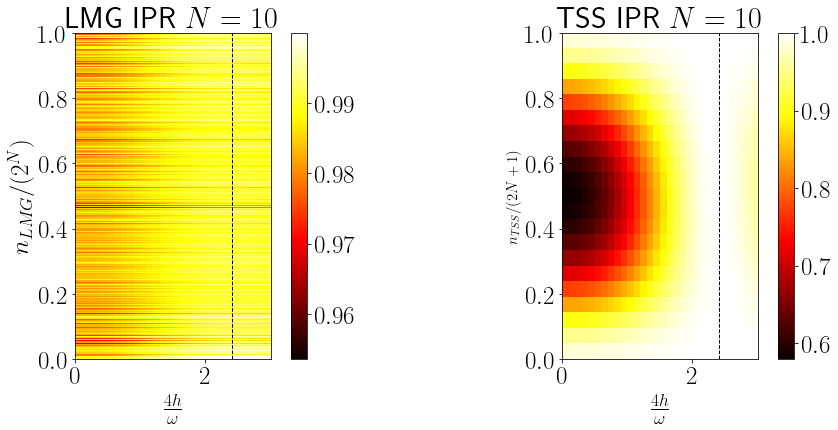

In [9]:
#---------------------------------------------------------------------------------------
"""
Now plot the data 
"""

fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
ax0.set_title(fr"LMG IPR $N ={N:3d}$")


## LMG

minmin = np.min(iprmat_lmg)
maxmax = np.max(iprmat_lmg)
asp = 5
ax0.set_xlabel(r'$\frac{4h}{\omega}$')
ax0.set_ylabel(r'$n_{LMG}/(2^N)$')
etas = 4 * hs/w

for pt in freezing_pts:
    ax0.axvline(x=pt, color='black', linestyle="--",linewidth=1.0)

pp1 = ax0.imshow(iprmat_lmg.T, aspect=asp, interpolation='None',\
                cmap='hot', origin='lower',\
           extent = [etas[0] ,etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)


fig.colorbar(pp1, orientation='vertical')


## TSS
ax1 = fig.add_subplot(122)
ax1.set_title(fr"TSS IPR $N ={N:2d}$")

minmin = np.min(iprmat_tss)
maxmax = np.max(iprmat_tss)
asp = 5

ax1.set_xlabel(r'$\frac{4h}{\omega}$')
ax1.set_ylabel(r'$n_{TSS}/(2N+1)$',fontsize= 15)
#ax1.yaxis.set_label_position("right")
#ax1.yaxis.tick_right()
etas = 4 * hs/w

for pt in freezing_pts:
    ax1.axvline(x=pt, color='black', linestyle="--",linewidth=1.0)

pp2 = ax1.imshow(iprmat_tss.T, aspect=asp, interpolation='None',\
                cmap='hot', origin='lower',\
           extent = [etas[0] ,etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(pp2, orientation='vertical')

figname = "compare_IPR-3d_LMG_TSS_N" + str(N) +".svg"
#plt.savefig(figname,dpi=200)

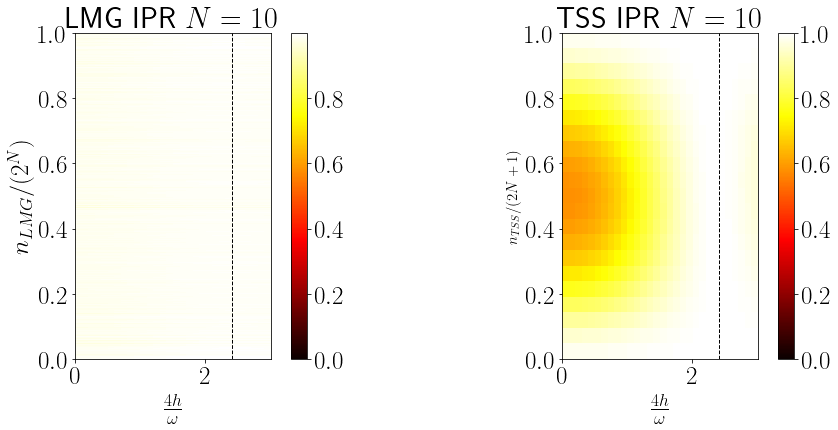

In [11]:
#---------------------------------------------------------------------------------------
"""
Now plot the data 
"""

fig = plt.figure(figsize=(16, 6))
ax0 = fig.add_subplot(121)
ax0.set_title(fr"LMG IPR $N ={N:3d}$")


## LMG

minmin = np.min(iprmat_lmg)
maxmax = np.max(iprmat_lmg)
asp = 5
ax0.set_xlabel(r'$\frac{4h}{\omega}$')
ax0.set_ylabel(r'$n_{LMG}/(2^N)$')
etas = 4 * hs/w

for pt in freezing_pts:
    ax0.axvline(x=pt, color='black', linestyle="--",linewidth=1.0)

pp1 = ax0.imshow(iprmat_lmg.T, aspect=asp, interpolation='None',\
                cmap='hot', origin='lower',\
           extent = [etas[0] ,etas[-1], 0 , 1], vmax=maxmax, vmin=0.0)


fig.colorbar(pp1, orientation='vertical')


## TSS
ax1 = fig.add_subplot(122)
ax1.set_title(fr"TSS IPR $N ={N:2d}$")

minmin = np.min(iprmat_tss)
maxmax = np.max(iprmat_tss)
asp = 5

ax1.set_xlabel(r'$\frac{4h}{\omega}$')
ax1.set_ylabel(r'$n_{TSS}/(2N+1)$',fontsize= 15)
#ax1.yaxis.set_label_position("right")
#ax1.yaxis.tick_right()
etas = 4 * hs/w

for pt in freezing_pts:
    ax1.axvline(x=pt, color='black', linestyle="--",linewidth=1.0)

pp2 = ax1.imshow(iprmat_tss.T, aspect=asp, interpolation='None',\
                cmap='hot', origin='lower',\
           extent = [etas[0] ,etas[-1], 0 , 1], vmax=maxmax, vmin=0.0)

fig.colorbar(pp2, orientation='vertical')

figname = "compare_IPR-3d_LMG-modified_TSS-original_N" + str(N) +".svg"
#plt.savefig(figname,dpi=200)